In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import sparse
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm

In [2]:
nloop=4000
burnin=1000
M=1000

In [3]:
data5=pd.read_csv('C:\\Users\\wuboyuan\\Desktop\\data5.csv',header=None)
data5=100*data5.apply(np.log).diff(1)[1:]
y=data5.T.values[0]
T=len(y)

# 先验分布参数

In [4]:
phih0=0.97
vphih=0.1**2
mu0=0
vmu=10
muh0=1
vmuh=10
nuh=5
sh=0.2**2*(nuh-1)

# 初始化马尔可夫链

In [5]:
muh=np.log(np.var(y))
phih=0.98
omegah2=0.2**2
h=muh+np.sqrt(omegah2)*np.random.randn(T,1)
exph=np.exp(h)

# 存储空间

In [6]:
store_theta=np.zeros([nloop-burnin,4])
store_h =np.zeros([nloop - burnin,T])
store_q =np.zeros([nloop - burnin,2])

# 循环外的计算

In [7]:
hphi=np.eye(T)-sparse.coo_matrix((phih*np.ones(T-1),(np.arange(1,T),np.arange(T-1))),shape=(T,T))
newnuh=T/2+nuh
counth=0
countphi=0

# MCMC

In [8]:
for loop in range(nloop):
    invdmu=1/vmu+sum(1./exph)
    muhat=(invdmu**(-1))*(1/vmu*mu0+sum((np.matrix(y).T)/exph))
    mu=muhat+((np.linalg.cholesky(np.matrix(invdmu)).T)**(-1))*np.random.randn(1)
    hish=hphi.T*sparse.coo_matrix((np.hstack(([float((1-phih**2)/omegah2)],1/float(omegah2)*np.ones(T-1))),(np.arange(T),np.arange(T))),shape=(T,T))*hphi
    deltah=(hphi**(-1))*np.vstack((muh,np.ones([T-1,1])*(1-phih)*muh))
    hishdeltah=hish*np.matrix(deltah)
    s2=np.power((np.matrix(y).T-mu),2)
    errh=1
    ht=h
    while errh>10**(-3):
        expht=np.exp(ht)
        sinvexpht=s2/expht
        fh=-0.5+0.5*sinvexpht
        gh=0.5*sinvexpht
        kh=hish+sparse.coo_matrix((gh.T.tolist()[0],(np.arange(T),np.arange(T))),shape=(T,T))
        newht=kh**(-1)*(fh+np.multiply(gh,ht)+hishdeltah)
        errh=max(abs(newht-ht)).tolist()[0][0]
        ht=newht

    cholhh=np.linalg.cholesky(kh)
    lph=lambda x: -0.5*(x-deltah).T*hish*(x-deltah)-0.5*sum(x)-0.5*np.exp(-x).T*s2
    logc=lph(ht).tolist()[0][0]+np.log(3)
    flag=0
    while flag==0:
        hc=ht+(cholhh.T)**(-1)*np.random.randn(T,1)
        alparc=(lph(hc)+0.5*(hc-ht).T*kh*(hc-ht)-logc).tolist()[0][0]
        if alparc>np.log(np.random.uniform(0,1)):
            flag=1


    alpar=(lph(h)+0.5*(h-ht).T*kh*(h-ht)-logc).tolist()[0][0]
    if alpar<0:
        alpmh=1
    elif alparc<0:
        alpmh=-alpar
    else:
        alpmh=alparc-alpar
    if alpmh>np.log(np.random.uniform(0,1)) or loop==0:
        h=hc
        exph=np.exp(h)
        counth=counth+1


    errh=np.vstack(((h[0]-muh)*np.sqrt(1-phih**2),h[1:]-float(phih)*h[:-1]-muh*(1-phih)))
    newsh=(sh+sum(np.power(errh,2))/2)[0]
    omegah2=1/(np.random.gamma(newnuh,1./newsh))

    xphi=np.matrix(h[:-1]-muh)
    yphi=np.matrix(h[1:]-muh)
    dphi=1/(1/vphih+xphi.T*xphi/omegah2)
    phihat=dphi*(phih0/vphih+xphi.T*yphi/omegah2)
    phic=phihat+np.sqrt(dphi)*np.random.randn(1)
    g=lambda x:-0.5*np.log(omegah2/(1-np.power(x,2)))-0.5*(1-np.power(x,2))/omegah2*(h[0]-muh)**2
    if abs(phic).tolist()[0][0]<0.999:
        alpmh=np.exp(g(phic)-g(phih))
        if alpmh.tolist()[0][0]>np.random.uniform(0,1):
            phih=phic
            countphi = countphi+1
            hphi=np.eye(T)-sparse.coo_matrix((((phih*np.ones(T-1)).tolist()[0])*np.ones(T-1),(np.arange(1,T),np.arange(T-1))),shape=(T,T))

    dmuh=1/(1/vmuh+((T-1)*(1-phih)**2+(1-phih**2))/omegah2)
    muhhat=dmuh*(muh0/vmuh+(1-phih**2)/omegah2*h[0]+(1-phih)/omegah2*sum(h[1:]-float(phih)*h[:-1]))
    muh=muhhat+np.sqrt(dmuh)*np.random.randn(1)

    if loop>burnin-1:
        i=loop-burnin-1
        store_h[i,:]=np.array(h.T)[0]
        store_theta[i,:]=[float(mu),float(muh),float(phih),float(omegah2)]
        u=(np.matrix(y).T-mu)/np.exp(h/2)
        rtmp=sts.acf(u,nlags=20)
        Q=T*(T+2)/(T-np.arange(21)[1:])*np.matrix(rtmp[1:]**2).T
        rtmp2=sts.acf(np.power(rtmp,2),nlags=20)
        Q2=T*(T+2)/(T-np.arange(21)[1:])*np.matrix(rtmp2[1:]**2).T
        store_q[i,:]=[float(Q),float(Q2)]

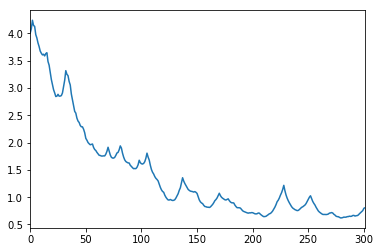

In [9]:
np.exp(pd.DataFrame(store_h)/2).mean().plot()
plt.show()

In [10]:
plt.figure(figsize=(20,22))
index=np.arange(0,12,3)
title=['mu','muh','phi','tau2']
for idx in range(len(index)):
    plt.subplot(4,3,1+index[idx])
    plt.plot(pd.DataFrame(store_theta)[idx])
    plt.title(title[idx])
    plt.xlabel('iteration')
    plt.subplot(4,3,1+index[idx]+1)
    plt.hist(pd.DataFrame(store_theta)[idx])
    ax1=plt.subplot(4,3,1+index[idx]+2)
    sm.graphics.tsa.plot_acf(pd.DataFrame(store_theta)[idx],lags=40,ax=ax1)
    plt.xlabel('lag')

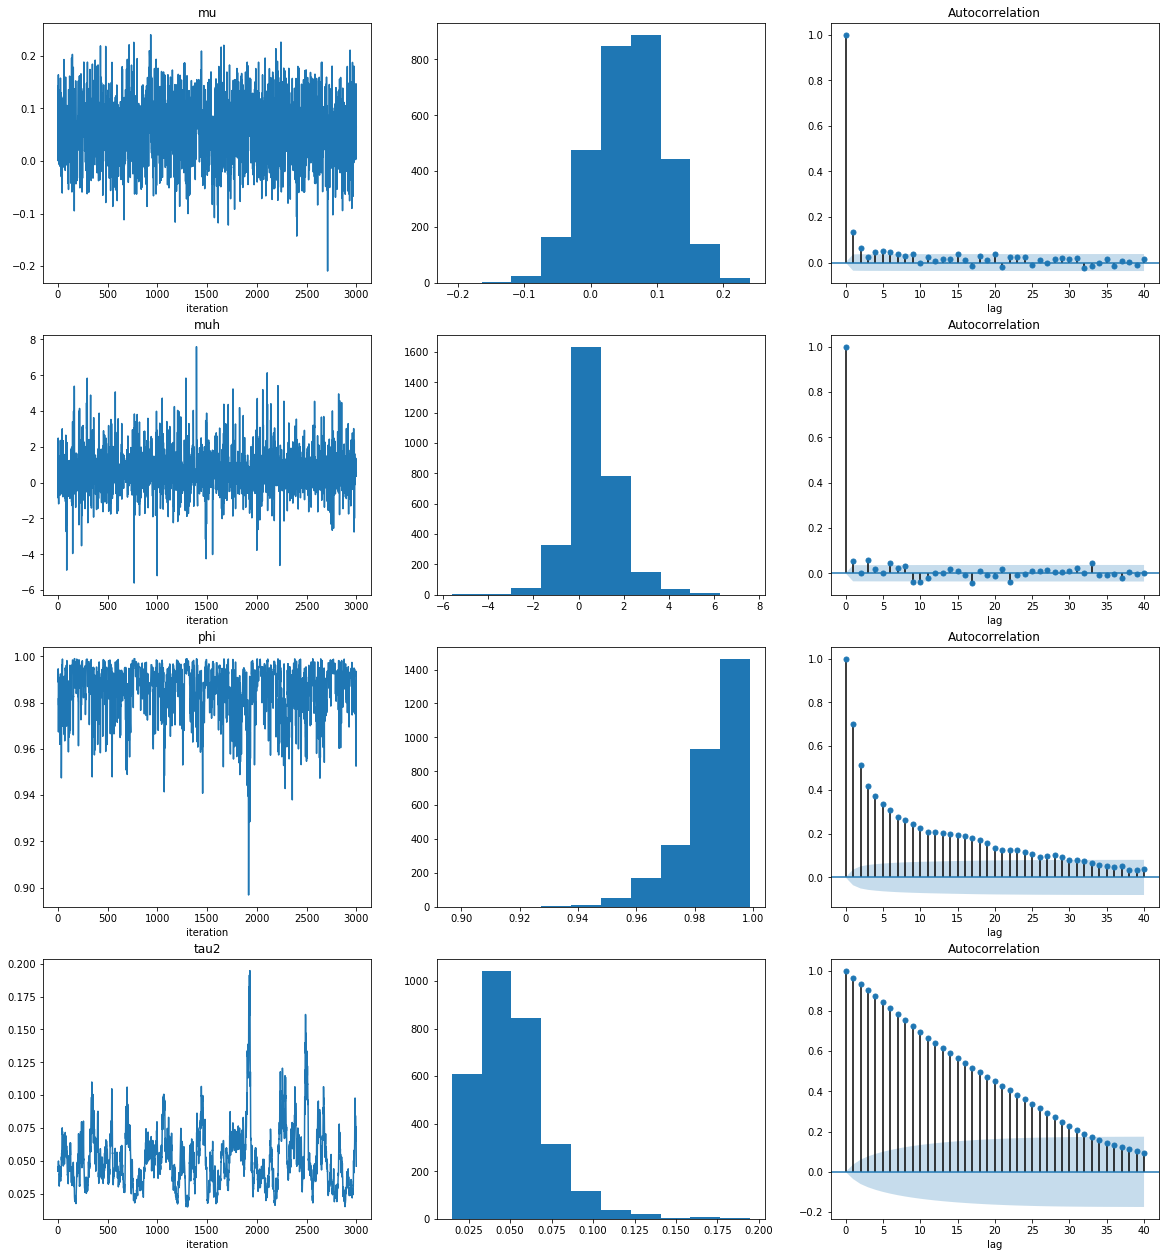

In [11]:
plt.show()

In [12]:
import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\sv_h.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow((pd.DataFrame(store_h)/2).T.index)
    writer.writerows((pd.DataFrame(store_h)/2).values)

import csv
with open('C:\\Users\\wuboyuan\\Desktop\\结果\\sv_theta.csv', 'w') as f:
    #f.write(codecs.BOM_UTF8)
    writer = csv.writer(f,lineterminator='\n')
    writer.writerow(pd.DataFrame(store_theta).T.index)
    writer.writerows(pd.DataFrame(store_theta).values)